# Feature Engineering - Özellik Mühendisliği

**1-) Feature Engineering Nedir ?**

Feature Engineering 'in amacı verilerimizi eldeki soruna daha uygun hale getirmektir. Yani modelimizin tahmin gücünü artırmak için hesaplama ve veri ihtiyaçlarını azaltmaya yönelik çalışmalara Feature Engineering denir.
* Bir özelliğin yararlı olması demek modelimizin öğrenmeye çalıştığı hedefle ilişkili olması anlamına geliyor. Örneğin doğrusal modellerimiz yalnızca doğrusal ilişkiler öğrenebilir. Bu nedenle bu modeli kullanırken ki amacımız özellikler ile hedef arasındaki ilişkiyi doğrusal hale getirmeye çalışmaktır. Özellik mühendisliğinde temel düşünce modelimizin en iyi performansı elde etmesi için hangi bilgileri kullanabileceğidir.


**Uygulama**

Bu fikirleri göstermek için, bir veri kümesine birkaç sentetik özellik eklemenin random forest kullanan modelimizin tahmin performansını nasıl değiştireceğine bakacağız. Beton veri seti, çeşitli beton formülasyonları ve elde edilen ürünün basınç dayanımını içerir; bir betonun ne kadar yük taşıyabileceğinin bir ölçüsüdür. Bu veri kümesinin görevi, formülasyonu göz önüne alındığında bir beton basınç dayanımını tahmin etmektir.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Önce modeli artırılmamış veri kümesi üzerinde eğiterek bir temel oluşturacağız. Bu, yeni özelliklerimizin gerçekten yararlı olup olmadığını belirlememize yardımcı olacaktır.

In [2]:
# ADIM 1

X = df.copy()
y = X.pop("CompressiveStrength")

# Verisetimizide değişiklik yapmadan modelimizi eğitelim ve skorlayalım..
baseline = RandomForestRegressor(criterion="mae", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"Temel modelimiz için MAE Skoru: {baseline_score:.4}")

Temel modelimiz için MAE Skoru: 8.232


In [3]:
# ADIM 2 
# Verisetimize 3 yeni özellik ekliyoruz.

X = df.copy()
y = X.pop("CompressiveStrength")

# sentetik özellikleri oluşturalım.
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# yeni özellikli datesetimiz ile modelimizi eğitelim ve skorlayalım.
model = RandomForestRegressor(criterion="mae", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"Yeni özellik eklenmiş hali ile modelimizin MAE Skoru: {score:.4}")

Yeni özellik eklenmiş hali ile modelimizin MAE Skoru: 7.948


Tabiki performans iyileştirildi. Bunun nedeni yeni oranlanmış özelliklerin, modelimizin daha önce tespit edemediği önemli bilgilerin içerdiği anlamına gelir.

**2-) Mutual Information - Karşılıklı Bilgi**

İki nicelik arasındaki ilişkiyi ölçmeye denir. Karşılıklı bilginin avantajı, herhangi bir ilişkiyi tespit edebilmesidir, korelasyon ise sadece doğrusal ilişkileri tespit eder. Hangi modeli kullanmak istediğinizi henüz bilemeyeceğiniz özellik geliştirmenin başlangıcında kullanışlıdır. 

Karşılıklı bilgi(MI) uygularken hatırlanması gereken bazı şeyler şunlardır:

* MI, bir özelliğin göreceli potansiyelini, kendisi tarafından düşünülen hedefin belirleyicisi olarak anlamanıza yardımcı olabilir.

* Bir özelliğin gerçek kullanışlılığı, kullandığınız modele bağlıdır. Bir özellik, yalnızca hedefle olan ilişkisinin modelinizin öğrenebileceği ölçüde yararlıdır. Bir özelliğin yüksek MI puanına sahip olması, modelinizin bu bilgilerle herhangi bir şey yapabileceği anlamına gelmez. İlişkilendirmeyi ortaya çıkarmak için önce özelliği dönüştürmeniz gerekebilir.

**Uygulama**

Otomobil veri seti, 1985 model yılına ait 193 otomobilden oluşmaktadır. Bu veri kümesinin amacı, bir otomobilin fiyatını (hedef) otomobilin marka, kaporta ve beygir gücü gibi özelliklerinin 23'ünden tahmin etmektir. Bu örnekte, özellikleri karşılıklı bilgilerle sıralayacağız ve sonuçları veri görselleştirmesiyle araştıracağız.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


MI skorlaması için sklearn algoritmaları ayrık özellikleri, sürekli özelliklerden farklı şekilde ele alır. Algoritmayı kullanırken bu durumu belirtmeliyiz. Genelde float veri tipine sahip olan bir özellik ayrık değildir. ( kategoriktir. ) Kategorik verileri label encoding yaparak sayısal hala getirmeyi biliyoruz.

In [5]:
X = df.copy()
y = X.pop("price")

# kategorik veriler için label encoding uygulanması.
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Tüm ayrık özelliklerin tam sayı türüne sahip olması gerekir. MI kullanmadan önce kontrol edelim.
discrete_features = X.dtypes == int

Scikit-learn'ün feature_selection modülünde iki karşılıklı bilgi ölçümü vardır: biri gerçek değerli hedefler için (mutual_ınfo_regression), diğeri kategorik hedefler için (mutual_ınfo_classif). Hedefimiz, fiyat, gerçek değerlidir.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def mi_skoru_hesapla(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = mi_skoru_hesapla(X, y, discrete_features)
mi_scores[::3]  # MI skoru ile birkaç özelliği gösterelim.

curb_weight          0.910254
highway_mpg          0.877894
length               0.610745
bore                 0.472753
drive_wheels         0.332645
symboling            0.230864
compression_ratio    0.095003
fuel_type            0.048120
Name: MI Scores, dtype: float64

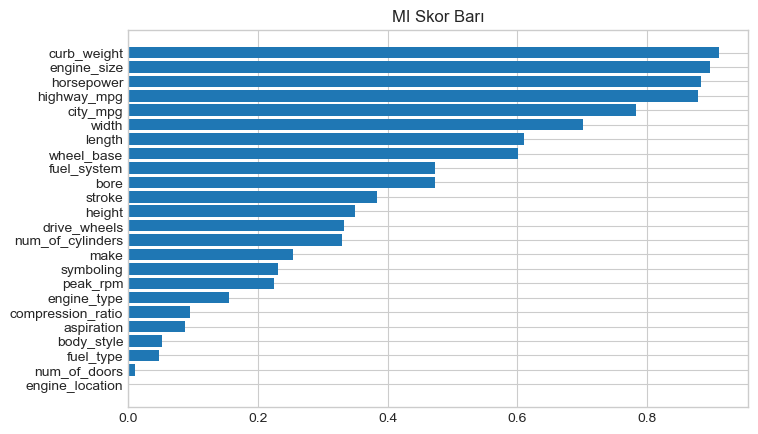

In [7]:
def plot_mi_skoru(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Skor Barı")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_skoru(mi_scores)

Tahmin edebileceğimiz gibi, yüksek puan alan curb_weight özelliği, hedef olan fiyatla güçlü bir ilişki sergiliyor.

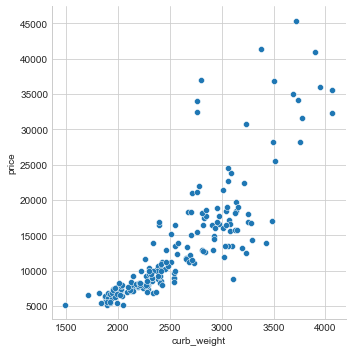

In [9]:
# curb_weight özelliği fiyatımızı hemen hemen doğrusal bir yönde etkiliyor.
# görselleştirelim.

sns.relplot(x="curb_weight", y="price", data=df);

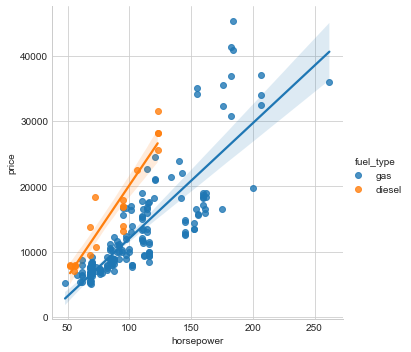

In [10]:
# Bir özelliğin MI puanından önemsiz olduğuna karar vermeden önce, olası etkileşim etkilerini araştırmak iyidir. 
# Alan bilgisi burada çok fazla rehberlik sunabilir.

sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);


**3-) Creating Features - Özellik Oluşturma**

İlk olarak kullanacağımız veriset'lerini yükleyelim.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("accidents.csv")
autos = pd.read_csv("autos.csv")
concrete = pd.read_csv("concrete.csv")
customer = pd.read_csv("customer.csv")

* 1-) Matematiksel Dönüşümler.

In [12]:
# "strok oranı", bir motorun performansa göre ne kadar verimli olduğunun bir ölçüsüdür.

autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


In [14]:
# motorun aldığı yol hesabı.
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

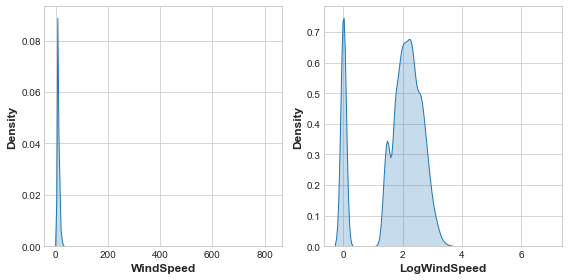

In [15]:
# kazalarda rüzgar hızının etkisini görebilmek için logaritmayı verinin üzerinde normalleştirme yapmak adına kullanıyoruz.
# bu zorunlu bir işlem değildir. bu işlemi yapmadan veriyi görselleştirmek istersek biraz çarpık bir görüntü elde edecektir.
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# karşılaştırma.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

* 2-) Counts.

In [16]:
# trafik kazalarına neden olan etkenlerin boolean olarak konumlandırılması.

roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In [18]:
# bu blokta ise betonu oluşturan özellikleri sayan dataframe yapısı bulunmaktadır.
# dataframe incelendiğinde özellik değeri 0 ise bileşenlere alınmıyor.

components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


* 3-) Yapı Oluşturma ve Parçalama.

Verilen datayı parçalara ayırarak ayrı sutünlara yazma işlemidir. Örneğin 0312 412 65 65 telefon numarasının sadece başındaki 0312 alınarak yeni bir kategori elde etmiş oluruz.

In [19]:
# customer datasetimizin policy kolonunu ayıralım ve ayrı iki sutun olarak yazalım.

customer[["Type", "Level"]] = (  # iki yeni özellik oluşturacağız.
    customer["Policy"]           # policy özelliğini kullanarak oluşturacağız.
    .str                         # str fonksiyonu aracılığı ile.
    .split(" ", expand=True)     # " " üzerinden bölerek.
                                 # ve sonucu ayrı sutünlar şeklinde yazacağız.
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


In [21]:
# ya da bu işlemin tam tersini yapabiliriz.

autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


* 4-) Group Transforms.

In [24]:
# Diğer kullanışlı yöntemler arasında max, mın, median, var, std ve count bulunur.

customer["AverageIncome"] = (
    customer.groupby("State")  # her il için.
    ["Income"]                 # geliri seçelim.
    .transform("mean")         # ve ortalamasını hesaplayalım. ve bunu da ayrı bir kolona yazalım.
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


In [25]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


**Özellikler Oluşturma ile İlgili İpuçları:**

* Özellikler oluştururken modelinizin kendi güçlü ve zayıf yönlerini akılda tutmak iyidir.
* Doğrusal modeller doğal olarak toplamları ve farklılıkları öğrenir, ancak daha karmaşık bir şey öğrenemez.
* Çoğu modelin öğrenmesi için oranlar zordur. Oran kombinasyonları genellikle bazı kolay performans kazanımlarına yol açar.
* Doğrusal modeller ve sinir ağları genellikle normalleştirilmiş özelliklerle daha iyi sonuç verir. Sinir ağları özellikle 0'dan çok uzak olmayan değerlere ölçeklendirilmiş özelliklere ihtiyaç duyar. Ağaç tabanlı modeller (rastgele ormanlar ve XGBoost gibi) bazen normalleşmeden yararlanabilir.
* Ağaç modelleri hemen hemen her özellik kombinasyonuna yaklaşmayı öğrenebilir, ancak bir kombinasyon özellikle önemli olduğunda, özellikle veriler sınırlı olduğunda, açıkça oluşturulmasından yararlanabilirler.
* Counts'lar özellikle ağaç modelleri için faydalıdır, çünkü bu modeller aynı anda birçok özellik arasında bilgi toplamanın doğal bir yoluna sahip değildir.

**4-) Clustering With K-Means**

K-Means ve LDA denetimsiz öğrenme'ye girer. Denetimsiz algoritmaların amacı özelliklerin yapısını belirli bir şekilde temsil etmektir. Feature Engineering kapsamında denetimsiz algoritmaları özellik bulma tekniği olarak düşünebiliriz.

Küme özellikleri kategoriktir. Ve modelimize bağlı olarak label encoding ya da onehot encoding uygulanması gerekir.

K-Means, normal düz çizgi mesafesini (başka bir deyişle Öklid mesafesi) kullanarak benzerliği ölçer. 

Sklearn üzerinde k-means için 3 ana parametre vardır. n_clusters, max_iter ve n_init.

K-Means şu şekilde çalışır:
    *Algoritma, bazı önceden tanımlanmış sayıda (n_clusters) centroıd'leri rasgele atayarak başlar. 
    *En yakın küme merkezine atama noktalarına olan mesafeyi en aza indirmek için her bir centroidi(kümeyi) hareket ettirin. Centroidler artık hareket etmeyene kadar veya bazı maksimum yineleme sayısı geçene kadar (max_iter) bu iki adım yinelenir.
    *n_init ise algoritmanın yineleme sayısıdır.

**Uygulama**

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# bu 3 özelliği kullanarak kümeler meydana getireceğiz.
df = pd.read_csv("housing.csv")
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [4]:
# kümelerimizi oluşturalım.
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,2
1,8.3014,37.86,-122.22,2
2,7.2574,37.85,-122.24,2
3,5.6431,37.85,-122.25,2
4,3.8462,37.85,-122.25,0


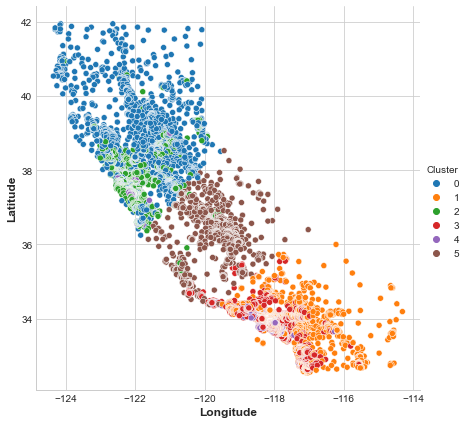

In [6]:
# veri üzerinde oluşturduğumuz kümelere göz atalım. algoritmamız kıyılarda bulunan ve 
# yüksek gelirli kişiler için yeni kümeler meydana getirmiş gibi görünüyor.

sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

Bu veri kümesindeki hedef medhouseval'dir (ortalama ev değeri). Aşağıdaki kutu grafikleri, hedefin her küme içindeki dağılımını gösterir. Kümeleme bilgilendirici ise, bu dağılımlar çoğunlukla MedHouseVal arasında ayrılmalıdır.

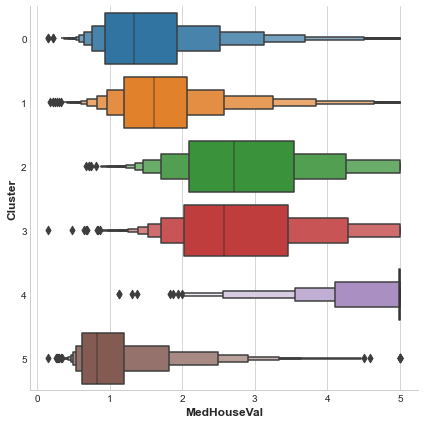

In [7]:
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

**5-) Principal Component Analysis ( PCA )**

Kümelemeyi, veri kümesinin yakınlığa dayalı bir bölümlemesi olduğu gibi, pca'yı verilerdeki varyasyonun bir bölümlemesi olarak düşünebiliriz. PCA, verilerdeki önemli ilişkileri keşfetmenize yardımcı olacak harika bir araçtır ve daha bilgilendirici özellikler oluşturmak için de kullanılabilir. PCA genellikle standartlaştırılmış verilere uygulanır.Yeni özellikler, verilerin temel bileşenleri olarak adlandırılır. 

* PCA yalnızca sayısal özelliklerle çalışır.
* Pca'yı uygulamadan önce verilerinizi standartlaştırmak iyi bir uygulamadır.
* Aykırı değerleri kaldırmayı veya kısıtlamayı düşünün, çünkü sonuçlar üzerinde aşırı bir etkiye sahip olabilirler.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("autos.csv")

In [9]:
# hedefimiz olan fiyat ile arasında yüksek MI puanına sahip 4 özelliği seçtik. 
# verilerimizi standartlaştıracağız.

features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# standartlaştırma
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [10]:
# artık sklearn üzerinden PCA kullanabiliriz ve temel bileşenlerimizi oluşturabiliriz.

from sklearn.decomposition import PCA

# PCA'ımızı oluşturalım.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# dataframe mimizi convert edelim.
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [11]:
loadings = pd.DataFrame(
    pca.components_.T,  # özellik yükleme matrisimiz.
    columns=component_names,  # sutunlarımız ana bileşendir.
    index=X.columns,  # ve satırlarımız orjinal özelliklerdir.
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


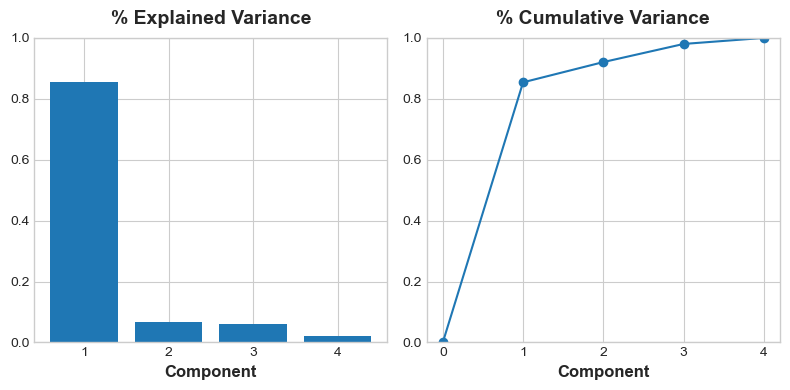

In [12]:
plot_variance(pca);

Bileşenlerin MI puanlarına da bakalım. Şaşırtıcı olmayan bir şekilde, PC1 oldukça bilgilendiricidir, ancak kalan bileşenler, küçük varyanslarına rağmen, fiyatla hala önemli bir ilişkiye sahiptir.

In [13]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014393
PC2    0.378947
PC3    0.306370
PC4    0.203612
Name: MI Scores, dtype: float64

In [14]:
# PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


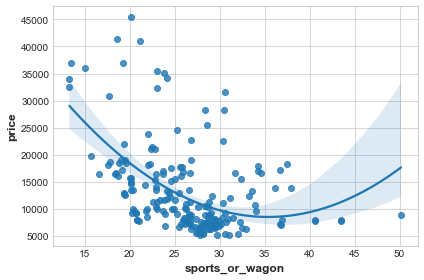

In [15]:
# Bu kontrastı ifade etmek için yeni bir oran özelliği oluşturalım.

df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

**6-) Target Encoding**

Bu derse kadar gördüğümüz konuların tamamı sayısal verilerimiz içindi. Bu yöntem ise kategorik verilerimiz içindir.

In [17]:
# datasetimizi yükleyelim.

import pandas as pd

autos = pd.read_csv("autos.csv")

*Hedef kodlama*, özellik kategorilerini hedeften türetilen bir sayı ile değiştiren her türlü kodlamadır.

In [20]:
# her aracın markasına göre ortalama fiyatı.
# bu tür hedef kodlamaya bazen ortalama kodlama denir. 

autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


Bu yöntemin en büyük sorunu overfitting e yol açma ihtimalinin çok yüksek olmasıdır. Bu soruna bir çözüm yumuşatma(smoothing) eklemektir. Buradaki fikir, kategori içi ortalamayı genel ortalamayla harmanlamaktır.

**Uygulama**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Benzersiz Zipcode'ların Sayısı: {}".format(df["Zipcode"].nunique()))

Benzersiz Zipcode'ların Sayısı: 3439


In [3]:
# Hedef kodlayıcıyı eğitmek için% 25'lik bir bölünme oluşturarak başlayacağız.
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

In [4]:
from category_encoders import MEstimateEncoder

# kodlayıcı örneği oluşturalım, gürültü i.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

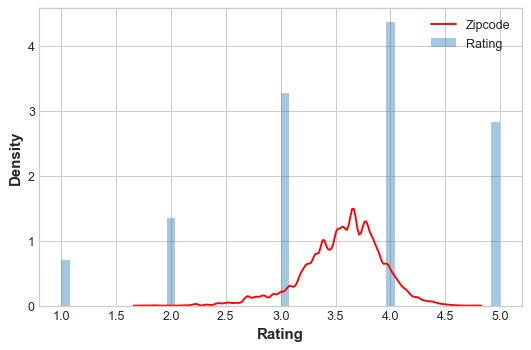

In [5]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);